In [1]:
!git clone https://github.com/Nikhil9786/Self-Driving-Car.git

Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 5338, done.
remote: Counting objects: 100% (5338/5338), done.
remote: Compressing objects: 100% (5336/5336), done.
remote: Total 5338 (delta 0), reused 5335 (delta 0), pack-reused 0
Receiving objects: 100% (5338/5338), 79.20 MiB | 40.73 MiB/s, done.


In [2]:
!ls Self-Driving-Car

driving_log.csv  IMG


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
## Store data
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,center,left,right,steering,throttle,reverse,speed
0,D:\OneDrive\Desktop\IMG\center_2020_11_30_14_21_12_549.jpg,D:\OneDrive\Desktop\IMG\left_2020_11_30_14_21_12_549.jpg,D:\OneDrive\Desktop\IMG\right_2020_11_30_14_21_12_549.jpg,0.0,0.0,0,0.000009
1,D:\OneDrive\Desktop\IMG\center_2020_11_30_14_21_12_614.jpg,D:\OneDrive\Desktop\IMG\left_2020_11_30_14_21_12_614.jpg,D:\OneDrive\Desktop\IMG\right_2020_11_30_14_21_12_614.jpg,0.0,0.0,0,0.000020
2,D:\OneDrive\Desktop\IMG\center_2020_11_30_14_21_12_681.jpg,D:\OneDrive\Desktop\IMG\left_2020_11_30_14_21_12_681.jpg,D:\OneDrive\Desktop\IMG\right_2020_11_30_14_21_12_681.jpg,0.0,0.0,0,0.000013
3,D:\OneDrive\Desktop\IMG\center_2020_11_30_14_21_12_754.jpg,D:\OneDrive\Desktop\IMG\left_2020_11_30_14_21_12_754.jpg,D:\OneDrive\Desktop\IMG\right_2020_11_30_14_21_12_754.jpg,0.0,0.0,0,0.000019
4,D:\OneDrive\Desktop\IMG\center_2020_11_30_14_21_12_822.jpg,D:\OneDrive\Desktop\IMG\left_2020_11_30_14_21_12_822.jpg,D:\OneDrive\Desktop\IMG\right_2020_11_30_14_21_12_822.jpg,0.0,0.0,0,0.000005


In [5]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_11_30_14_21_12_549.jpg,left_2020_11_30_14_21_12_549.jpg,right_2020_11_30_14_21_12_549.jpg,0.0,0.0,0,0.000009
1,center_2020_11_30_14_21_12_614.jpg,left_2020_11_30_14_21_12_614.jpg,right_2020_11_30_14_21_12_614.jpg,0.0,0.0,0,0.000020
2,center_2020_11_30_14_21_12_681.jpg,left_2020_11_30_14_21_12_681.jpg,right_2020_11_30_14_21_12_681.jpg,0.0,0.0,0,0.000013
3,center_2020_11_30_14_21_12_754.jpg,left_2020_11_30_14_21_12_754.jpg,right_2020_11_30_14_21_12_754.jpg,0.0,0.0,0,0.000019
4,center_2020_11_30_14_21_12_822.jpg,left_2020_11_30_14_21_12_822.jpg,right_2020_11_30_14_21_12_822.jpg,0.0,0.0,0,0.000005


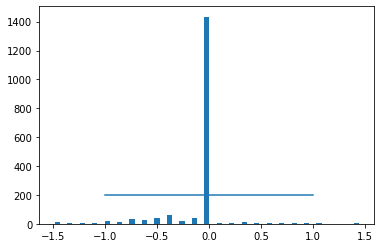

In [6]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 1776
Removed: 1234
Remaining: 542


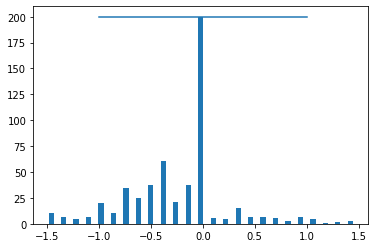

In [7]:
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 433
Valid Samples: 109


Text(0.5, 1.0, 'Validation set')

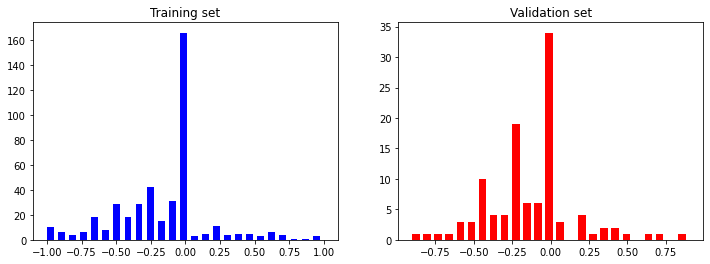

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

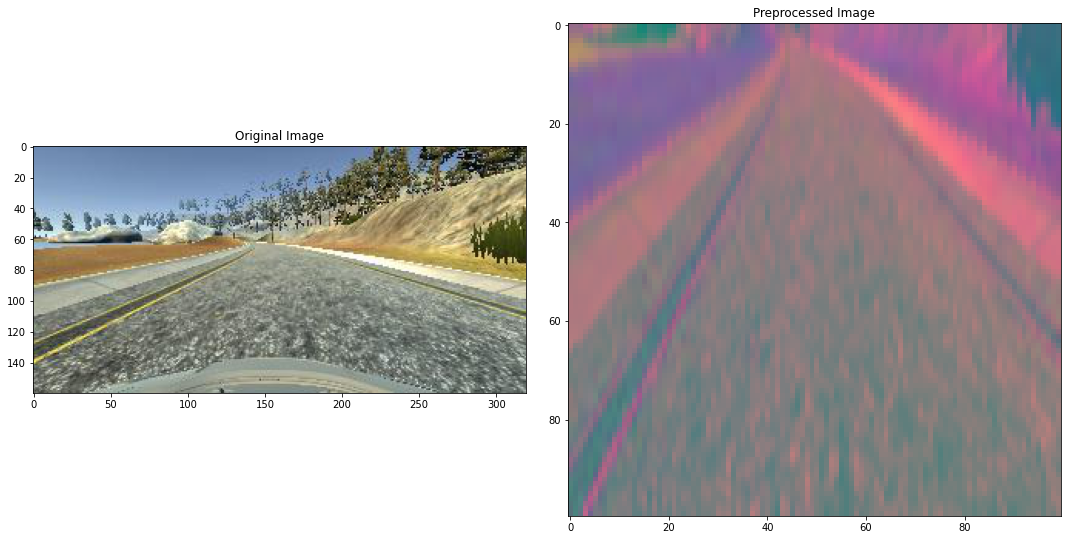

In [11]:
## Get any image
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [12]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(433, 100, 100, 3)


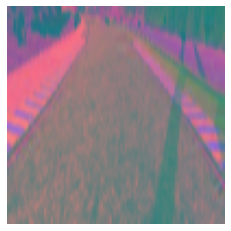

In [13]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [14]:
from keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [15]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fce813c2dd8> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fce7c9b97b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fce7c9b9b70> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fce7c190160> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fce7c190668> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fce7c190470> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fce81341d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fce20742c88> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fce20761d68> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fce20768c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fce20768b00> False
<tensorflow.python.keras.laye

In [19]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [20]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3276900   
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)               

In [22]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/100
4/4 [==============================] - 1s 281ms/step - loss: 9.5277 - accuracy: 0.2471 - val_loss: 1.1483 - val_accuracy: 0.3119
Epoch 2/100
4/4 [==============================] - 0s 81ms/step - loss: 4.1408 - accuracy: 0.2633 - val_loss: 0.1905 - val_accuracy: 0.3119
Epoch 3/100
4/4 [==============================] - 0s 81ms/step - loss: 5.1314 - accuracy: 0.2402 - val_loss: 0.4614 - val_accuracy: 0.3119
Epoch 4/100
4/4 [==============================] - 0s 81ms/step - loss: 3.8135 - accuracy: 0.2702 - val_loss: 0.8593 - val_accuracy: 0.3119
Epoch 5/100
4/4 [==============================] - 0s 82ms/step - loss: 3.6304 - accuracy: 0.2887 - val_loss: 0.9574 - val_accuracy: 0.3119
Epoch 6/100
4/4 [==============================] - 0s 80ms/step - loss: 3.0170 - accuracy: 0.2702 - val_loss: 0.8087 - val_accuracy: 0.3119
Epoch 7/100
4/4 [==============================] - 0s 81ms/step - loss: 2.8816 - accuracy: 0.2679 - val_loss: 0.6510 - val_accuracy: 0.3119
Epoch 8/100
4/4 [==

Text(0.5, 0, 'Epoch')

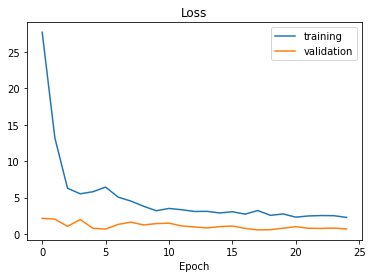

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')